In [41]:
from sqlalchemy import create_engine

# MySQL connection parameters
host= 'localhost'
user= 'josh'
password= 'go$T4GS'
database= 'data_4999'

# Create MySQL connection
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")

In [42]:
from sqlalchemy import text
import pandas as pd

# SQL query to pull desired data for the most recent CostReport data for all Providers
query = """
        SELECT c.prov_id, c.ownership, c.tot_fixed_assets, c.total_other_assets, c.tot_current_assets, c.net_income_from_service_to_patients, c.tot_other_income
        FROM CostReports c
        JOIN (
                SELECT prov_id, MAX(fiscal_end) AS max_fiscal_end
                FROM CostReports
                GROUP BY prov_id
        ) m ON c.prov_id = m.prov_id AND c.fiscal_end = m.max_fiscal_end
        """

# Perform the query using the engine and load the results to a dataframe
with engine.connect() as connection:
    result = connection.execute(text(query))
    df = pd.DataFrame(result.fetchall(), columns=result.keys())
    engine.dispose()

In [43]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing
categorical_cols = ['ownership', 'loc_type']
quantitative_cols = ['tot_fixed_assets', 'total_other_assets', 'tot_current_assets', 'net_income_from_service_to_patients', 'tot_other_income']

# Define imputers for different data types
imputer_categorical = SimpleImputer(strategy= 'most_frequent')  # Impute with most frequent value for categorical data
imputer_quantitative = SimpleImputer(strategy= 'median')  # Impute with median for quantitative data

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer_categorical', imputer_categorical),
            ('encoder', OneHotEncoder())
        ]), categorical_cols),
        ('quant', Pipeline([
            ('imputer_quantitative', imputer_quantitative),
            ('scaler', StandardScaler())
        ]), quantitative_cols)
    ])

In [44]:
from sklearn.pipeline import Pipeline
from umap.umap_ import UMAP
from sklearn.cluster import DBSCAN

# Clustering pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('scale_factor_total_assets', scale_total_assets),
    ('umap', UMAP(n_components=2)),  # for dimensionality reduction using UMAP
    ('clustering', DBSCAN())
])

# Fit the pipeline
pipeline.fit(df.drop(columns=['prov_id']))

# Transform data and predict clusters
transformed_data = pipeline.named_steps['umap'].transform(pipeline.named_steps['preprocessor'].transform(df.drop(columns=['prov_id'])))
clusters = pipeline.named_steps['clustering'].labels_

ValueError: A given column is not a column of the dataframe

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate silhouette score
silhouette = silhouette_score(transformed_data, clusters)

# Calculate Davies-Bouldin index
davies_bouldin = davies_bouldin_score(transformed_data, clusters)

# Add cluster labels to the DataFrame
df['cluster'] = clusters

# Print clustering metrics
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.42317813634872437
Davies-Bouldin Index: 0.4214405120825472


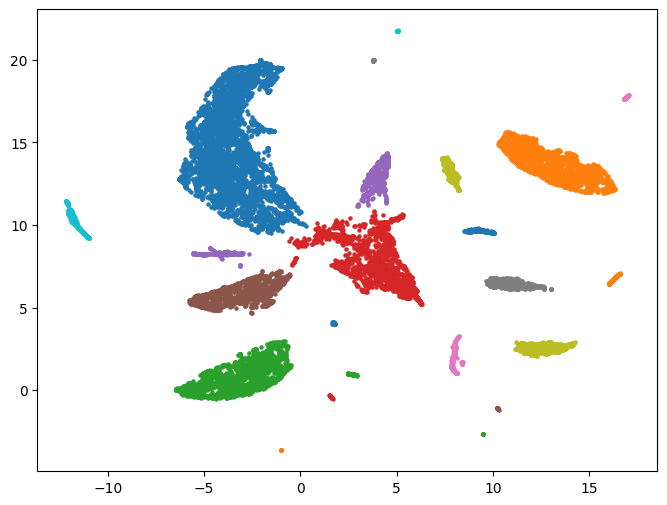

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for clustering visualization
plt.figure(figsize=(8, 6))
for cluster in df['cluster'].unique():
    plt.scatter(transformed_data[df['cluster'] == cluster, 0], transformed_data[df['cluster'] == cluster, 1], s= 5)
plt.show()